In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_penalty_lam_coef
seed = cfg_seed
env_str=cfg_env
penalty_lam_coef=cfg_penalty_lam_coef
num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter2_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-05-17 17:32:17.447143


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
    "penalty_lam_coef" : penalty_lam_coef
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter1")

iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter1 ckpt_iwvi_pendulum_policy_optimization_iter1
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-0.6931)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-3.1185)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(11.7200)
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter1
train_loss:  -2.4086218363046648
valid_loss:  -2.797899951171875
weight_alpha 1.0 h_min_tilde -6.1621165 ell_tilde -2.486477459278107 kappa_tilde 0.005215951812369215


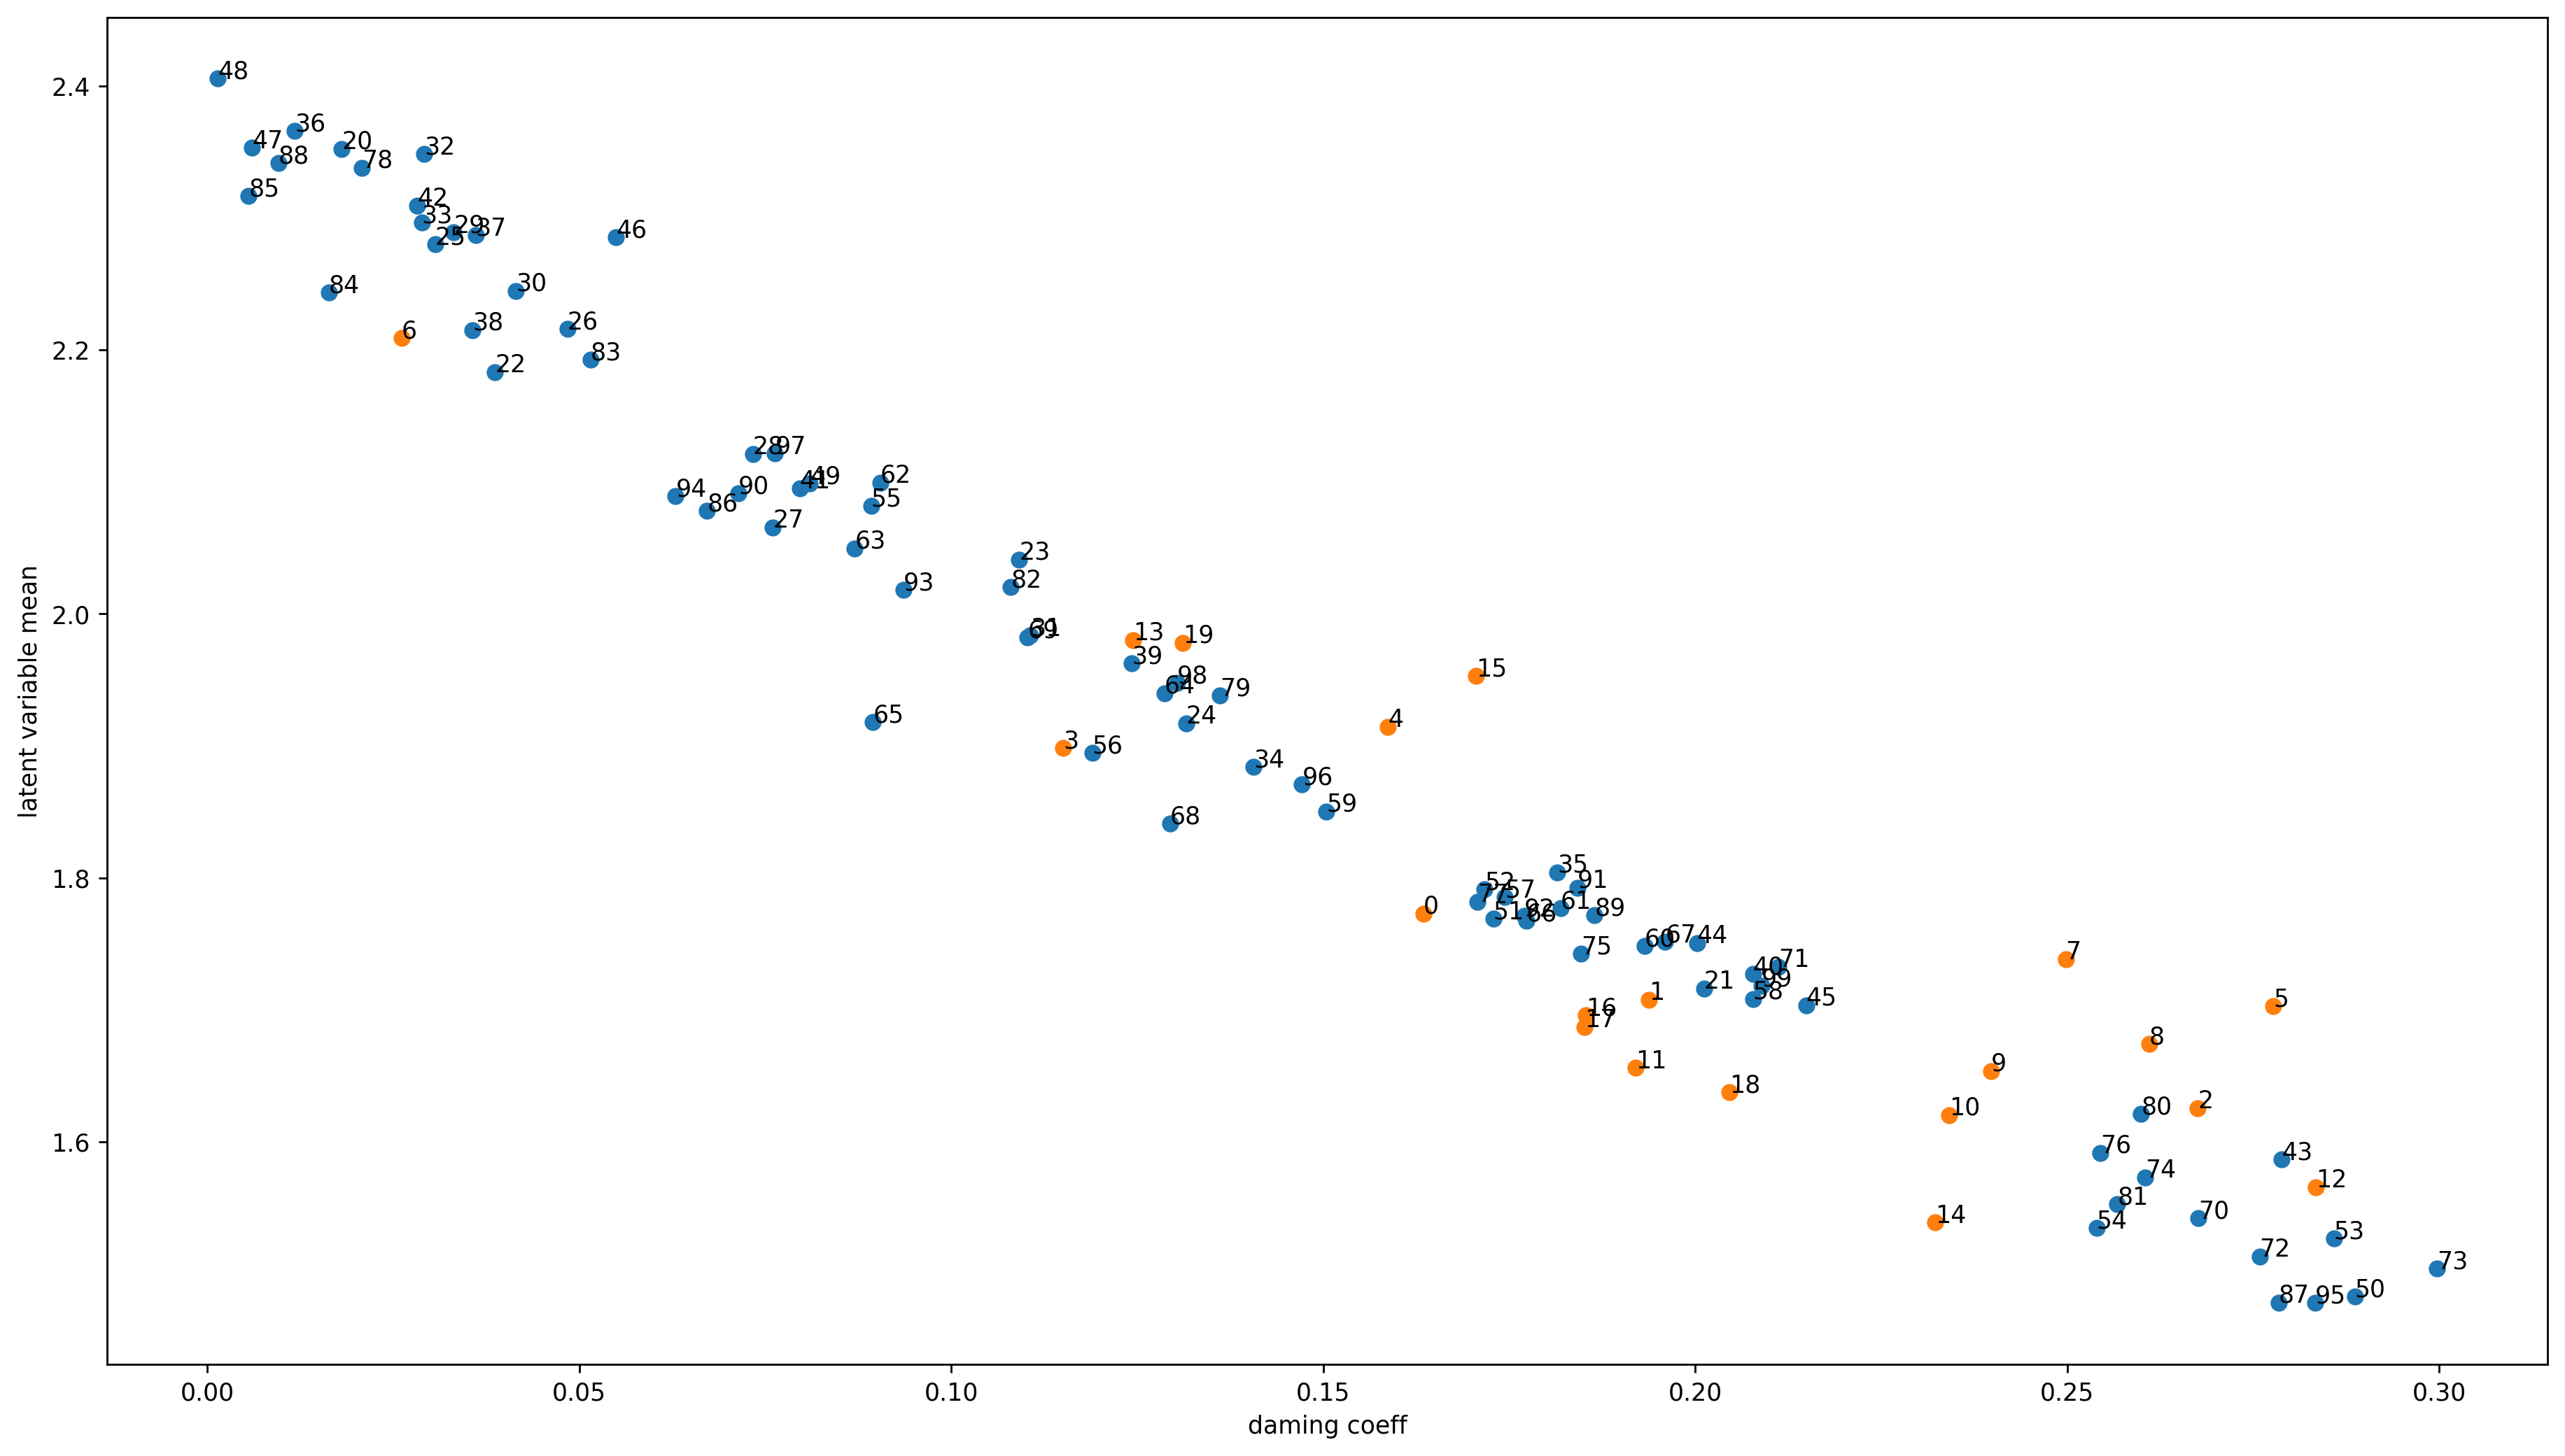

[0.16346495 0.19376823 0.2675319  0.11503246 0.15866848 0.27767899
 0.02613879 0.24978595 0.26100364 0.23974757]
[0.23415875 0.19197631 0.28340068 0.12439858 0.23227011 0.17053018
 0.18529065 0.1850802  0.20454609 0.13110959]
[0.01806764 0.20119136 0.03867789 0.10911323 0.13158045 0.03061344
 0.04839286 0.07598748 0.07332768 0.03311254]
[0.04145489 0.11061755 0.02913038 0.02882952 0.14059536 0.18145366
 0.01175634 0.03605897 0.03561832 0.1242789 ]
[0.20774164 0.07961685 0.02818215 0.27878886 0.20022311 0.21489816
 0.05495741 0.00603226 0.00140864 0.08100239]
[0.28865656 0.1728472  0.17167557 0.2858247  0.2539226  0.08923109
 0.11895172 0.17438186 0.20775948 0.15039731]
[0.19319706 0.18191796 0.09047245 0.08702328 0.12863061 0.0894847
 0.17726183 0.19596025 0.12942553 0.11026856]
[0.26757701 0.21116658 0.27584478 0.2996541  0.26043782 0.18466787
 0.25440247 0.17073022 0.0207501  0.1360628 ]
[0.2599147  0.256741   0.10799342 0.0514889  0.0163014  0.00555654
 0.06717741 0.27842439 0.00955

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.9318649768829346

 2 6.666949987411499

 3 6.935818672180176

 4 6.760645866394043

 5 6.8258726596832275

 6 6.863253355026245

 7 6.961057424545288

 8 4.180962562561035

 9 3.161170244216919

 10 3.2188262939453125

 11 3.04162335395813

 12 3.0932514667510986

 13 3.175154685974121

 14 3.107957124710083

 15 3.0649101734161377

 16 3.139732837677002

 17 3.18315052986145

 18 3.1952555179595947

 19 3.109506607055664

 20 3.2525625228881836

 21 3.253542423248291

 22 3.1295690536499023

 23 3.107865333557129

 24 2.977173089981079

 25 3.1391944885253906

 26 3.289567708969116

 27 6.417622327804565

 28 6.554446697235107

 29 6.935197830200195

 30 6.529320240020752

 31 6.705136775970459

 32 6.669865369796753

 33 6.688111782073975

 34 7.109419107437134

 35 7.0169517993927

 36 6.818168640136719

 37 6.690658807754517

 38 6.772278785705566

 39 6.599809885025024

 40 6.552918434143066

 41 6.449340105056763

 42 6.585653781890869

 43 6.5778257846832275

 44 4.8345787

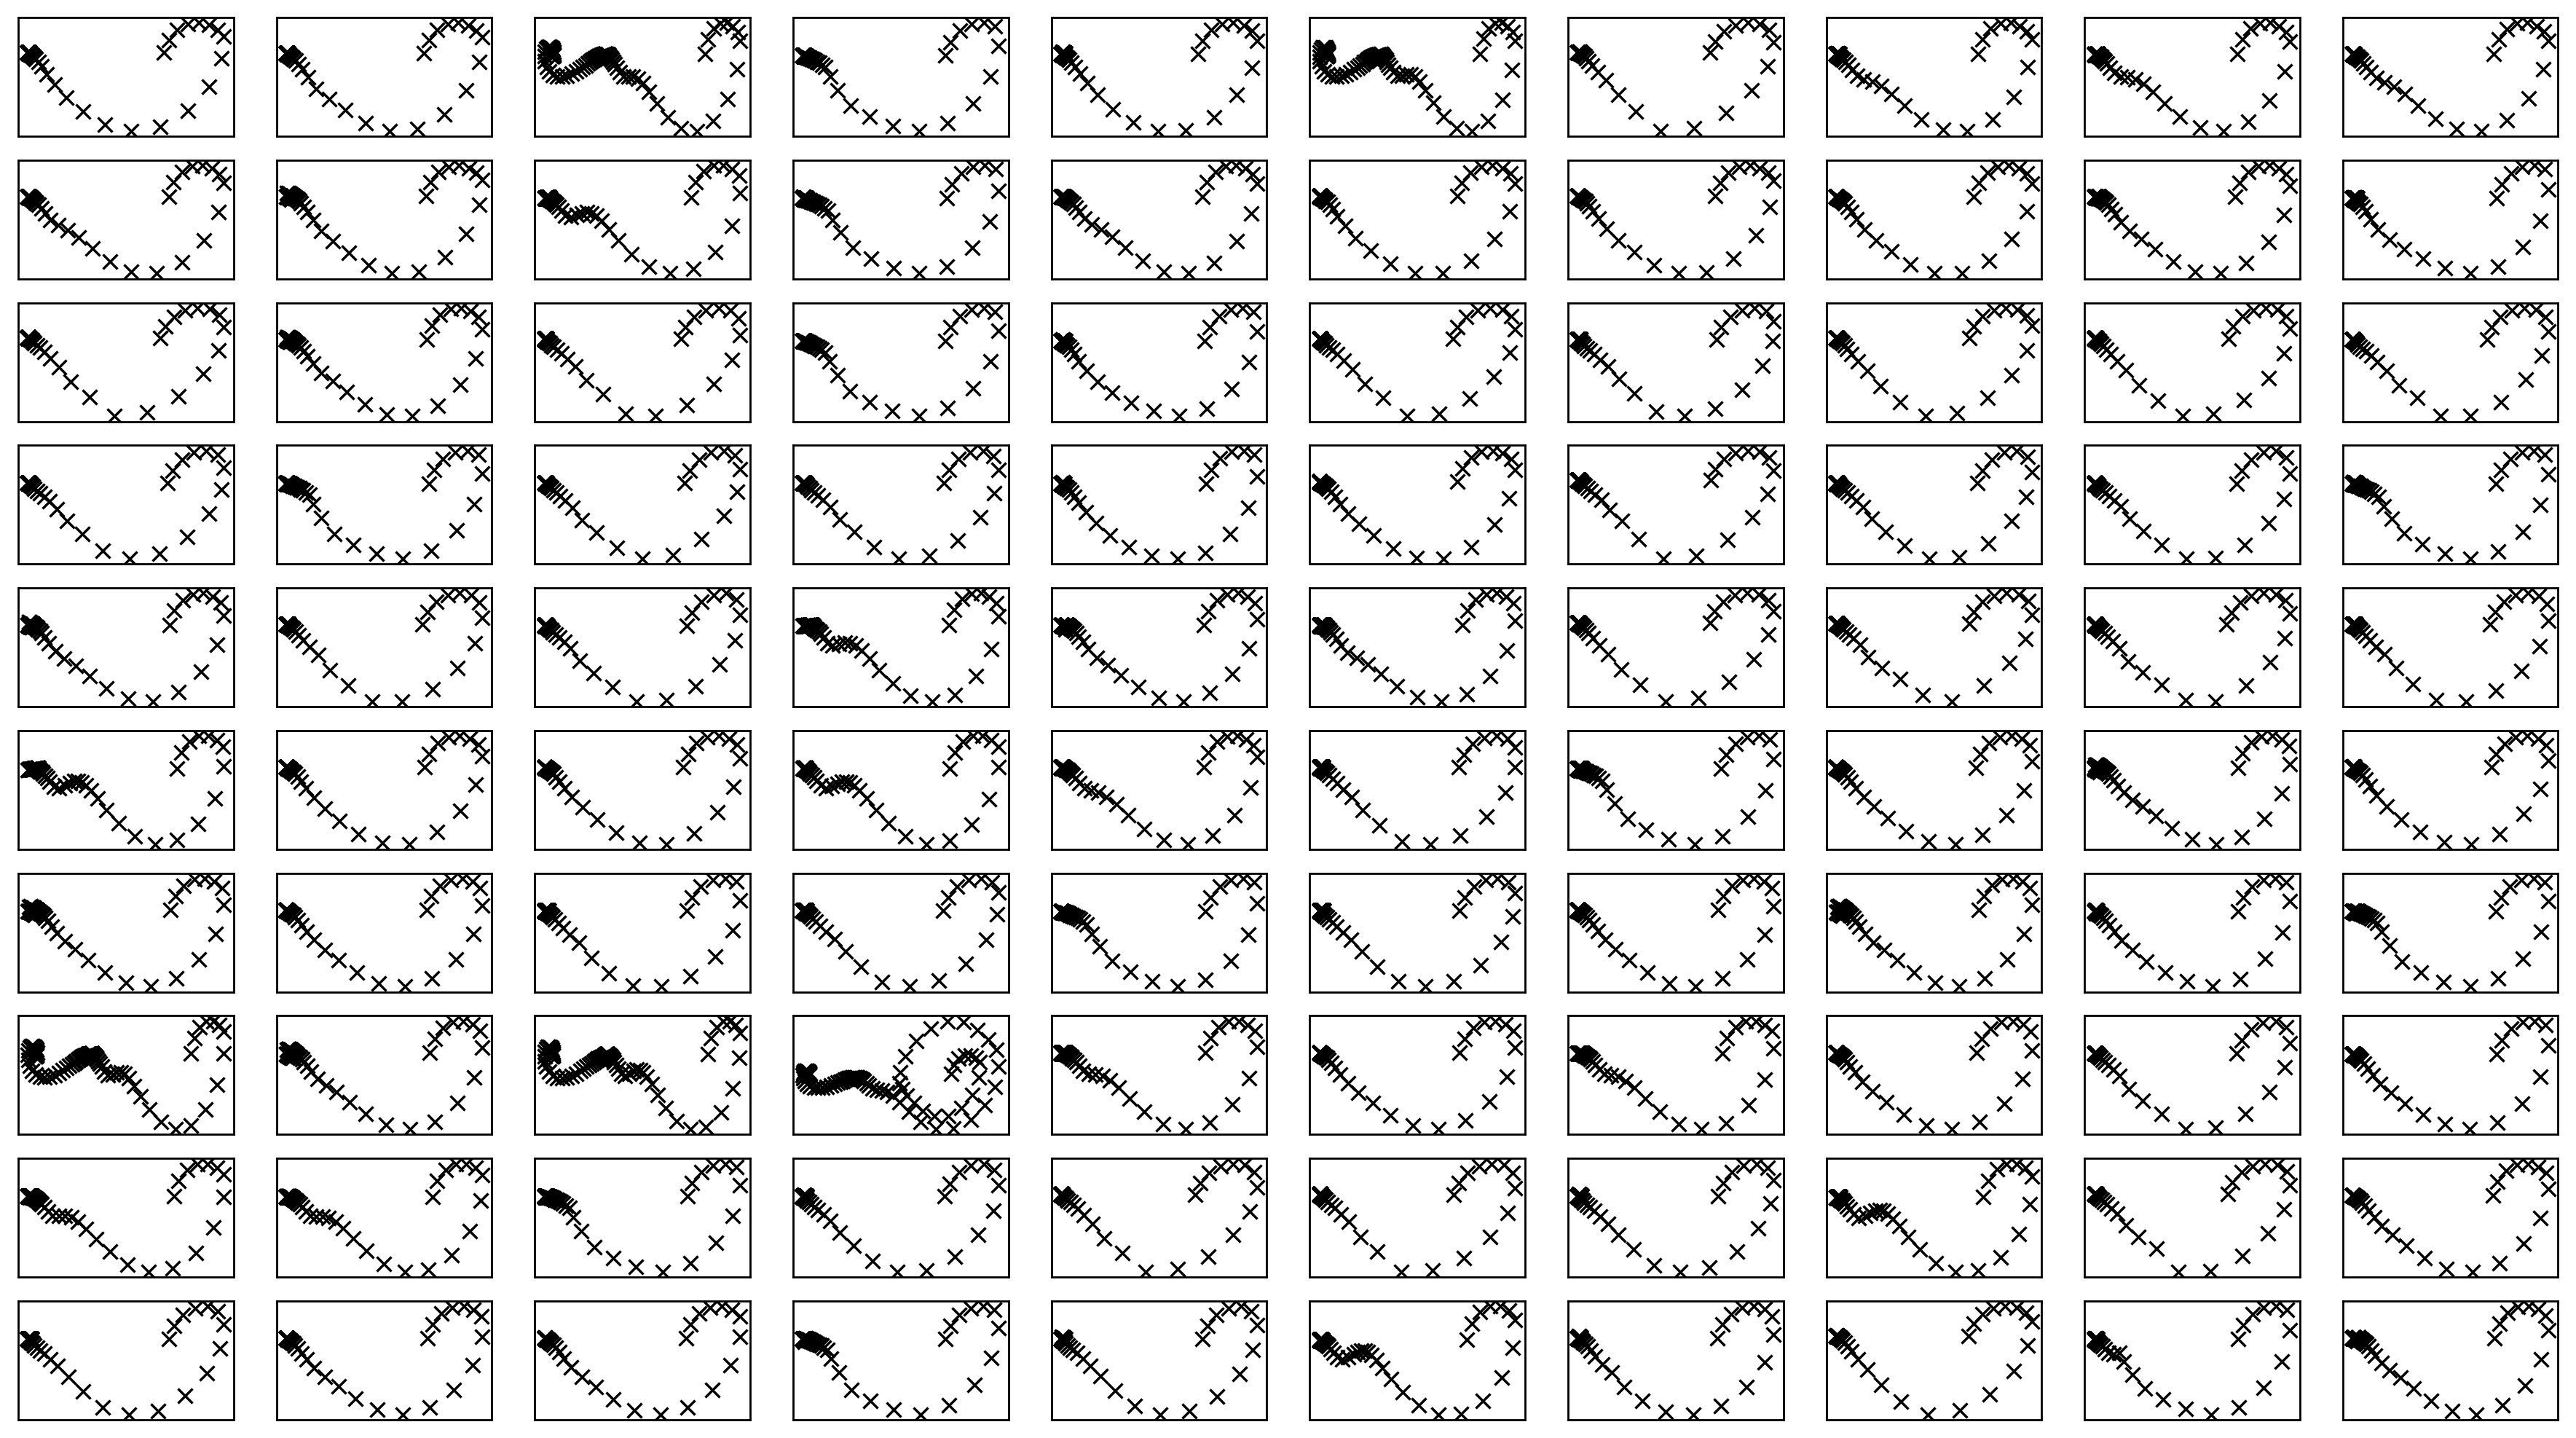

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.901336193084717

 2 4.9933247566223145

 3 6.99951696395874

 4 6.930939197540283

 5 6.918769359588623

 6 6.849073886871338

 7 6.801367521286011

 8 6.681059837341309

 9 6.693578243255615

 10 6.8295300006866455

 11 6.9024434089660645

 12 6.724749803543091

 13 4.281972885131836

 14 6.852190256118774

 15 6.657338619232178

 16 6.472234487533569

 17 6.814375400543213

 18 6.72506046295166

 19 6.643092632293701

 20 6.761667728424072

 21 6.617946624755859

 22 4.698545217514038

 23 3.2438464164733887

 24 3.270709991455078

 25 7.087295293807983

 26 7.035432815551758

 27 4.897152423858643

 28 3.4921042919158936

 29 4.337254524230957

 30 6.859577178955078

 31 6.698996067047119

 32 4.40421462059021

 33 3.241612195968628

 34 3.163104295730591

 35 3.1476895809173584

 36 3.119495391845703

 37 3.152878522872925

 38 3.1273903846740723

 39 3.467005491256714

 40 3.0135860443115234

 41 3.2061824798583984

 42 3.131558656692505

 43 3.29559

実環境方策rollout vs Sim環境方策rollout


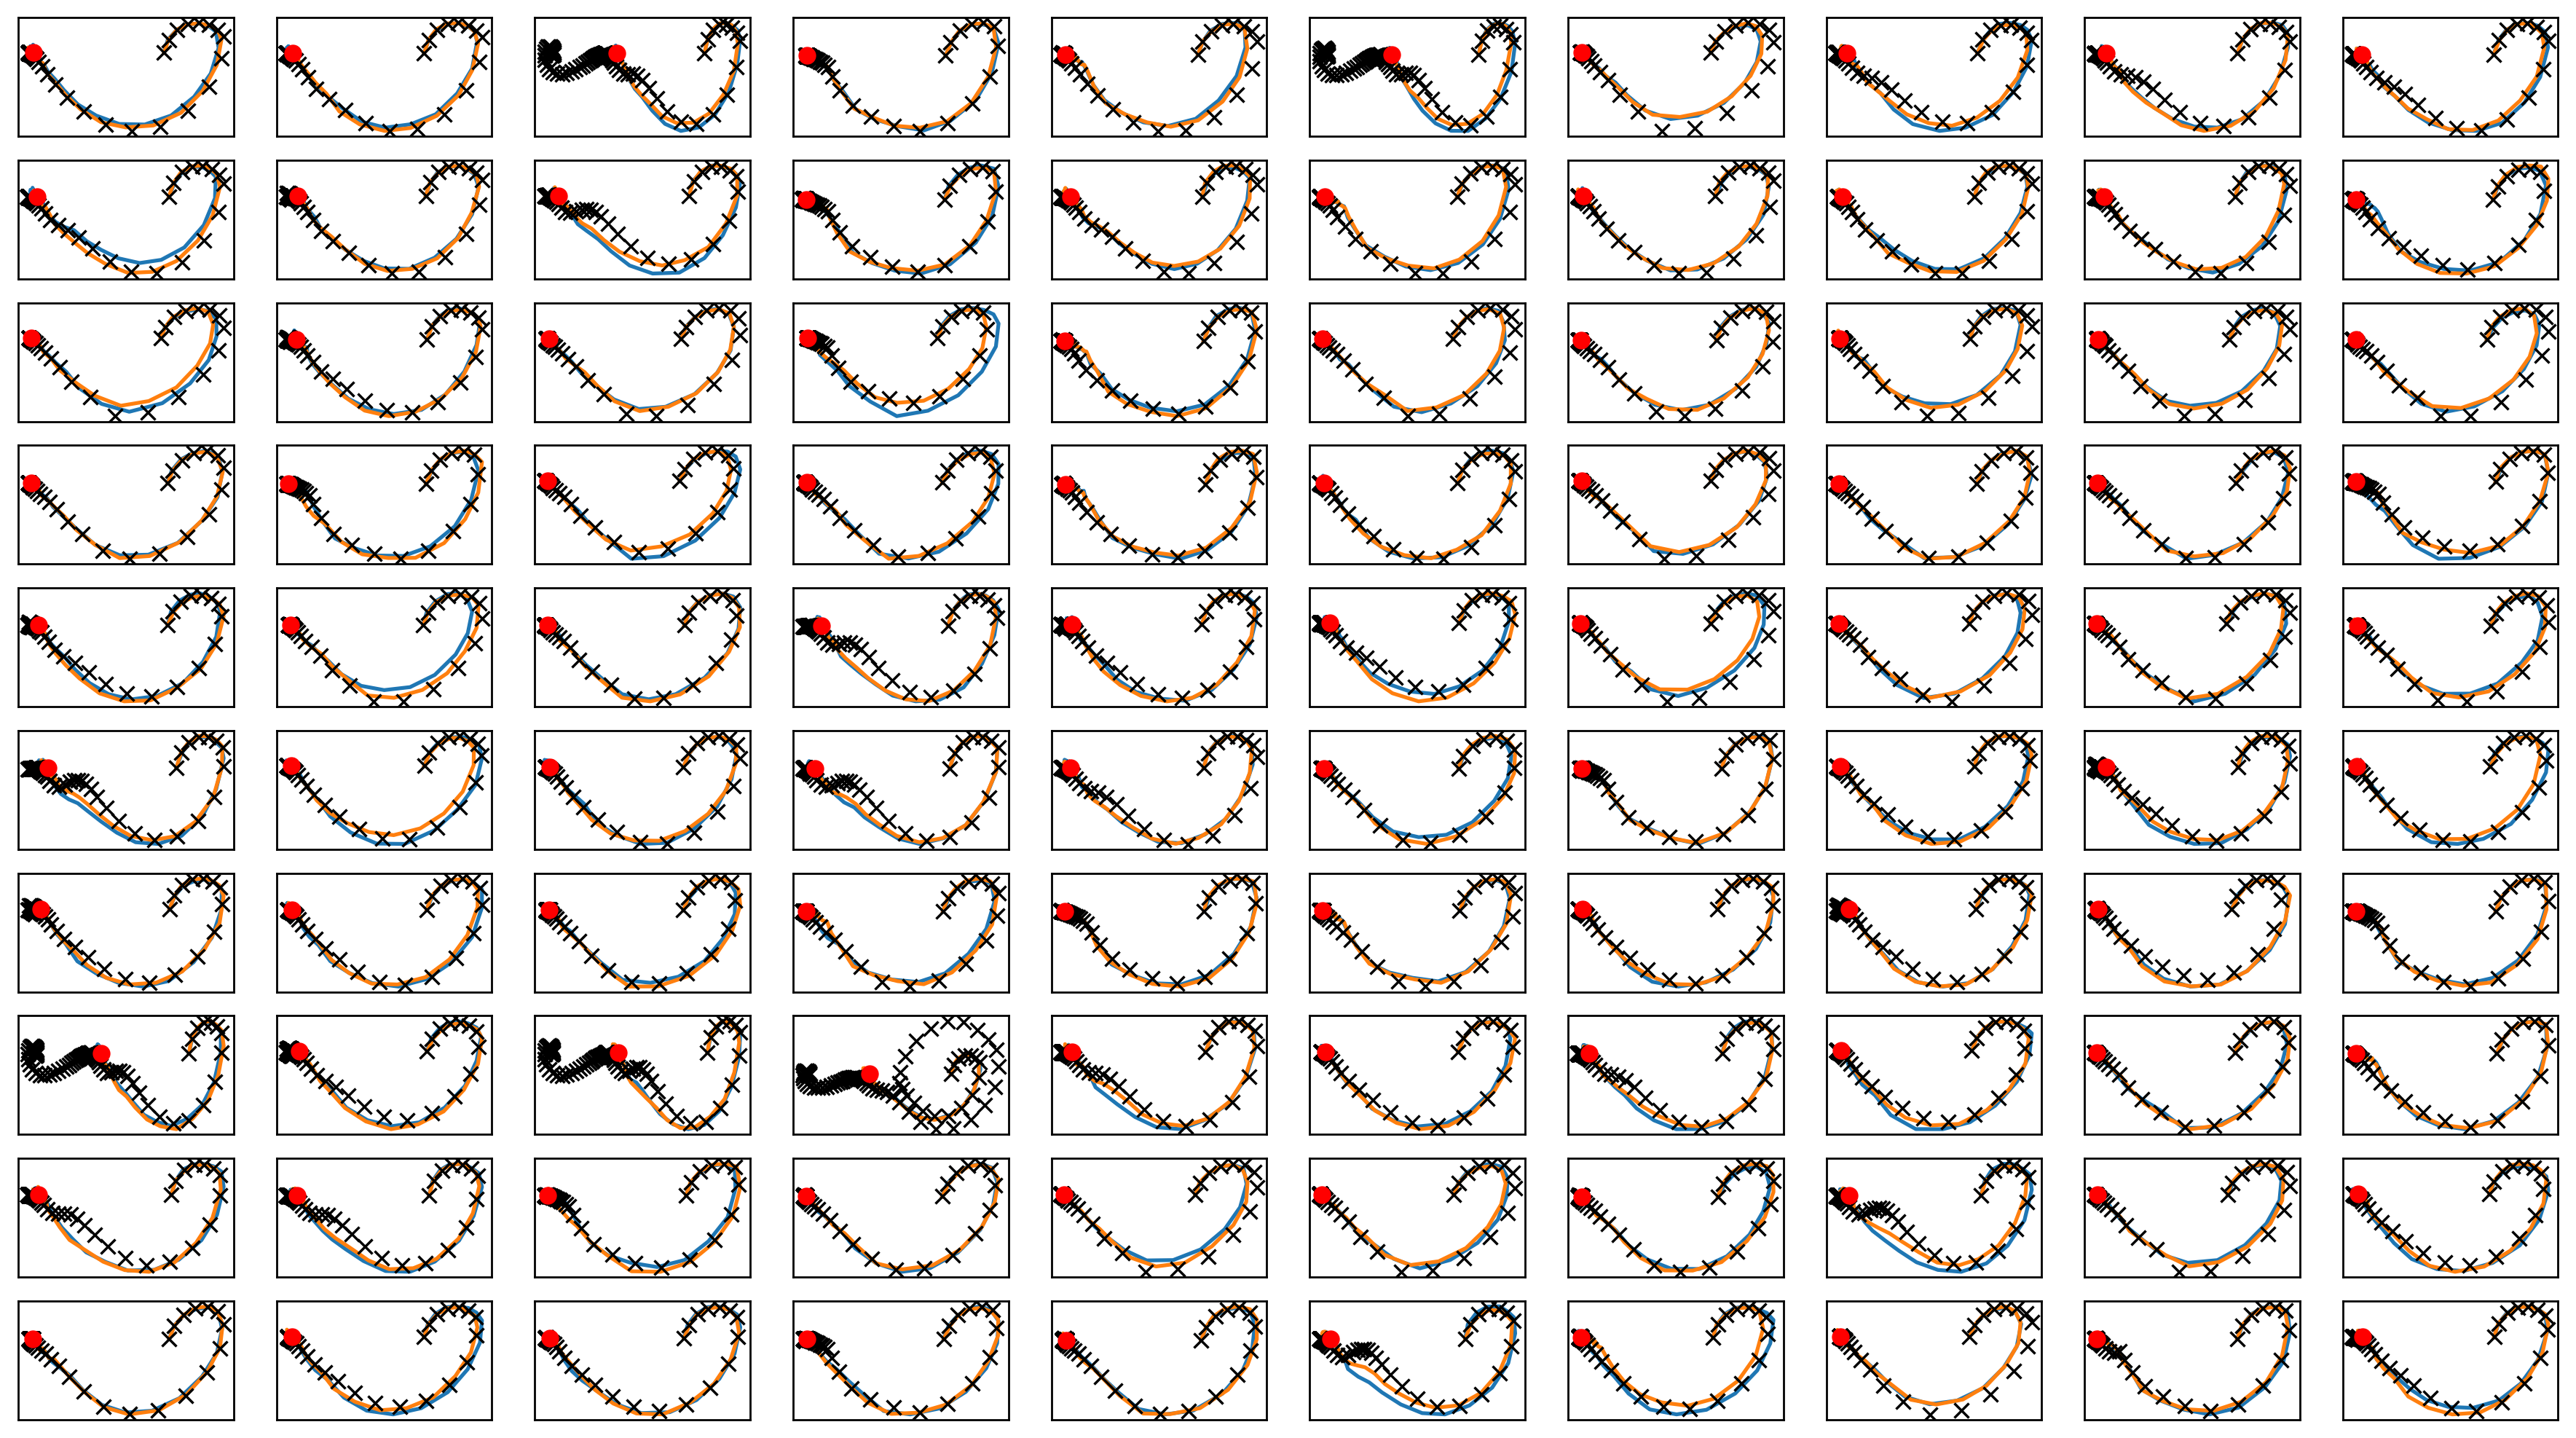

In [9]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [10]:
print(datetime.datetime.now())

2023-05-17 17:54:07.540442
